In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# to use astropy healpix
import astropy_healpix as hp
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic
from astropy.io import fits
from astropy import units as u
from astropy.io import fits

In [3]:
#opening the CMB data
data_mask = fits.open('COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
data_refined = fits.open('COM_CMB_IQU-smica-nosz_2048_R3.00_full.fits')

In [4]:
# with data_mask and data_refined make unrefined data
data_mask.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002769A9D4EC8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002769A9EA788>]>

In [5]:
data_refined.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x000002769A9DCCC8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x000002769A9ECE88>]>

In [6]:
data_mask[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    4 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.esa.int/web/planck/pla/                              
COMMENT  -------------------------------------------------------------          
COMMENT                     

In [8]:
data_refined[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    8 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
COMMENT  -------------------------------------------------------------          
COMMENT  Products from SMICA component separation method                        
COMMENT  -------------------------------------------------------------          
COMMENT  Further details in the Planck Legacy Archive and Explanatory Supplement
COMMENT  http://www.cosmos.e

In [9]:
nside_mask = data_mask[1].header['NSIDE']
order_mask = data_mask[1].header['ORDERING']
nside_map = data_refined[1].header['NSIDE']
order_map = data_refined[1].header['ORDERING']
hp_mask = HEALPix(nside=nside_mask, order=order_mask, frame=Galactic())
hp_map = HEALPix(nside=nside_map, order=order_map, frame=Galactic()) 
print(nside_mask,nside_map)

2048 2048


In [10]:
print(hp_mask.npix,hp_map.npix)
print(hp_mask.pixel_area,hp_map.pixel_area)
print(hp_mask.pixel_resolution,hp_map.pixel_resolution)

50331648 50331648
2.4967135219492856e-07 sr 2.4967135219492856e-07 sr
1.717743205908703 arcmin 1.717743205908703 arcmin


In [13]:
# the data will be (N_theta * N_phi) matrix
N_theta = 5000
N_phi = 2*N_theta
N = N_theta * N_phi

In [14]:
phi = np.linspace(0., 360., N_phi) * u.deg
theta = np.linspace(-90., 90., N_theta) * u.deg
phi_grid, theta_grid = np.meshgrid(phi, theta)

In [15]:
from astropy.coordinates import SkyCoord
coords = SkyCoord(phi_grid.ravel(), theta_grid.ravel(), frame='icrs')

In [16]:
temperature_map = data_refined[1].data['I_STOKES_INP']
tmap= hp_map.interpolate_bilinear_skycoord(coords, temperature_map)
hist_data_map= tmap
tmap = tmap.reshape((N_theta,N_phi))

In [17]:
temperature_mask = data_mask[1].data['TMASK']
tmap_mask = hp_mask.interpolate_bilinear_skycoord(coords, temperature_mask)
hist_data_mask= tmap_mask
tmap_mask = tmap_mask.reshape((N_theta,N_phi))

Text(0, 0.5, 'Declination (ICRS)')

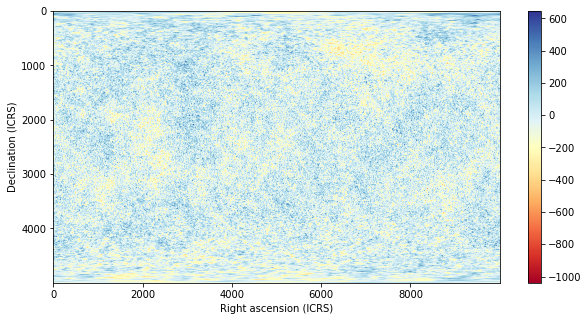

In [18]:
plt.figure(figsize=(10, 5))
im = plt.imshow(tmap, extent=None, cmap=plt.cm.RdYlBu, aspect='auto')
plt.colorbar(im)
plt.xlabel('Right ascension (ICRS)')
plt.ylabel('Declination (ICRS)')

108.07973398671692
-2.5949957780983715


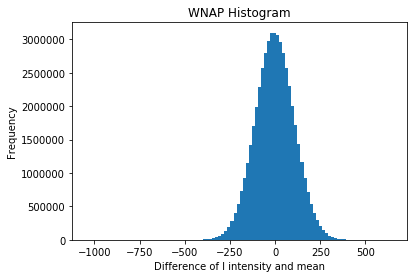

In [21]:
mean = np.mean(hist_data_map)
Sigma = np.std(hist_data_map)
plt.xlabel('Difference of I intensity and mean')
plt.ylabel('Frequency')
plt.title('WNAP Histogram')
plt.hist(hist_data_map,100);
print(Sigma)
print(mean)

In [23]:
image = np.copy(tmap) # final masked data. zero and one matrix
n = 2 
image[(image<n*Sigma+mean)] = 2000
image[(image != 2000)] = 0
image[(tmap_mask) == 0] = 0

Text(0, 0.5, 'theta')

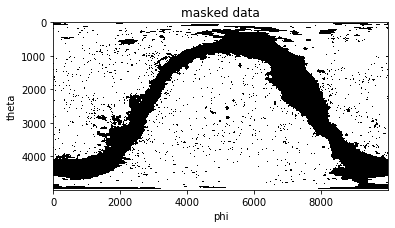

In [26]:
plt.imshow(image,cmap='gray')
plt.title('masked data')
plt.xlabel('phi')
plt.ylabel('theta')